In [39]:
# %%  imports 
import numpy as np
import pandas as pd
import os
from pyextremes import EVA
import pyextremes

In [2]:
snr_array = np.genfromtxt('channel_1597_SNR.csv', dtype='float',delimiter=',')

In [3]:
def get_list_simulations(root_dir):
    """
    Get a list with all the name of the simulation csv files.
    """
    file_list_simulations = []
    for _, file in enumerate(os.listdir(root_dir)):
        file_list_simulations.append(file)
    return file_list_simulations

def get_dict_scenario_txt(file_list_simulations):
    """
    Build dictionary of scenario number and the corresponding name of the csv file
    with simulation data.
    """
    simulation_files_dict = {}
    for file_name in file_list_simulations:
        if file_name.endswith('.docx'):
            continue
        else:
            #simulation_files_dict[str(file_name.split("_")[1]) + '_' + str(file_name.split("_")[3].rstrip('.txt'))] = file_name
            simulation_files_dict[str(file_name.split("_")[1])] = file_name
    return simulation_files_dict
def read_txt_to_series(file, root_dir):
    """
    read individual channel txt file to a df
    """
    file_path = os.path.join(root_dir, file)
    #df = pd.read_csv(file_path, sep='\t', index_col=0, parse_dates = True, squeeze=True)
    #columns = ["Q-factor", "Power", "CD", "PMD"] 
    df = pd.read_csv(file_path, sep='\t', parse_dates = True, squeeze=True)
    columns = ["Date","Q-factor", "Power", "CD", "PMD"] 
    df.columns = columns
    #df = convert_objects_to_float(df)
    return df
def convert_objects_to_float(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convert columns with object dtype to floats in order to use them in models.
    """
    indicator = df.dtypes == 'object'
    categorical_columns = df.columns[indicator].tolist()
    for col in categorical_columns:
        try:
            df[col] = df[col].astype('float')
        except:
            continue
    return df

In [4]:
# get files and make a dictionary 
root_dir = '/Users/joshnevin/Desktop/MicrosoftDataset'
file_list_simulations= get_list_simulations(root_dir)
simulation_files_dict = get_dict_scenario_txt(file_list_simulations)

In [5]:
channel = '1597'
df = read_txt_to_series(simulation_files_dict[channel], root_dir)
df = df.drop(columns=['Power','CD','PMD'])
df['Date'] = pd.to_datetime(df['Date'], format='%Y.%m.%d.%H.%M.%S')
df = df.set_index('Date')
series = df.squeeze()

Need to work out how best to split the timeseries up into contiguous batches. One crude way would be to convert the time column to timestamps as before and use this to find the indices. There is probably a clever way to do it using Pandas that does not involve converting the datetimes to timestamps.

In [6]:
def find_time_discontinuities(series) -> list:
    """
    Find the discontinuties for a given channel.
    input: series of SNR measurements
    output: 
    """
    disc_inds= []
    for i in range(len(series)-1):
        if series.index[i+1] - series.index[i] != \
        pd._libs.tslibs.timedeltas.Timedelta('0 days 00:15:00'):
            disc_inds.append(i)
    return disc_inds
def get_contiguous_batch(series, start_ind, stop_ind) -> series: 
    """
    Obtain a given contiguous batch of data
    input: series of values, start-stop indices 
    output: contiguous batch of data, batch length
    """
    return series[start_ind:stop_ind], len(series[start_ind:stop_ind])

In [14]:
disc_inds = find_time_discontinuities(series)
contiguous_batch, batch_len = get_contiguous_batch(series, disc_inds[2]+1, disc_inds[3])
batch_len
cont_batch_lens = [get_contiguous_batch(series, disc_inds[i]+1, disc_inds[i+1])[1] for i in range(len(disc_inds)-1)]

In [15]:
max(cont_batch_lens)

3979

<AxesSubplot:xlabel='Date'>

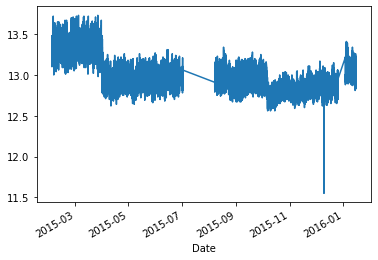

In [16]:
series.plot()

<AxesSubplot:xlabel='Date'>

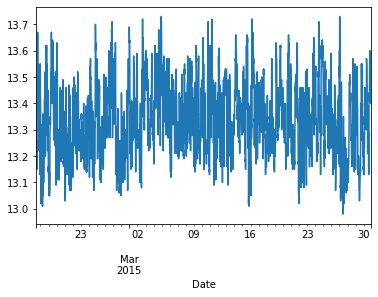

In [17]:
contiguous_batch.plot()

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Date', ylabel='Q-factor'>)

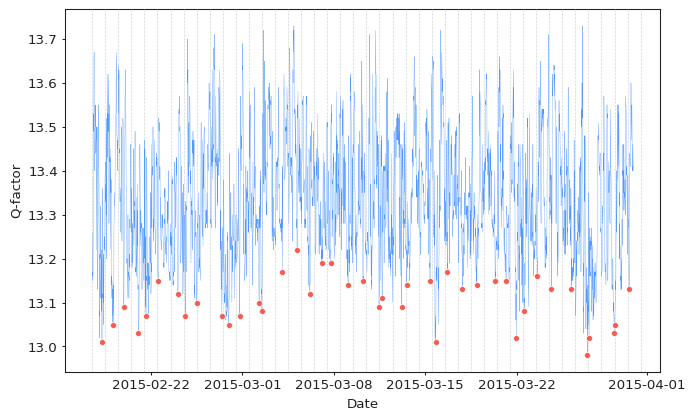

In [18]:
model_BM = EVA(contiguous_batch)
model_BM.get_extremes(method="BM", block_size="1D", extremes_type='low')
model_BM.plot_extremes()

In [19]:
model_BM.fit_model()

/Users/joshnevin/ext_val_stats/evs_env/lib/python3.8/site-packages/pyextremes/eva.py:1478: UserWarning: You passed a edgecolor/edgecolors ('None') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_pdf.scatter(


(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='Q-factor'>,
  <AxesSubplot:title={'center':'Probability density plot'}, xlabel='Q-factor', ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

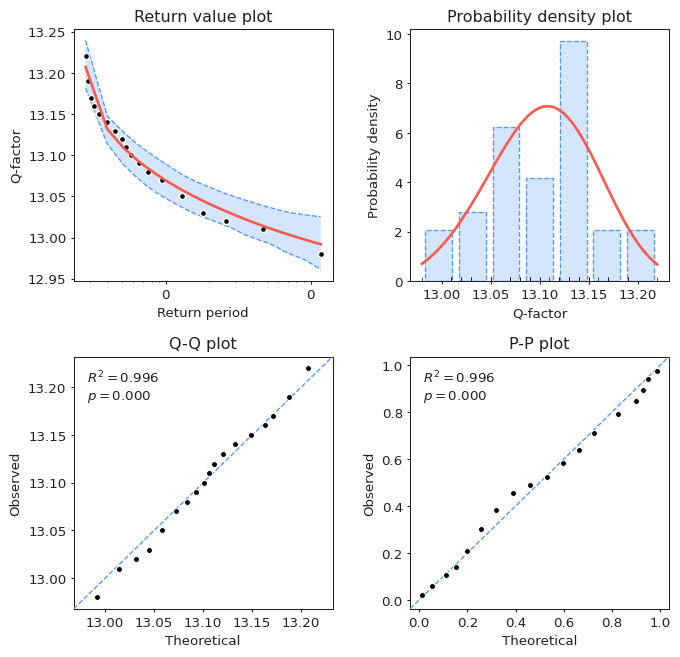

In [20]:
model_BM.plot_diagnostic(alpha=0.95)

Peaks over threshold 

Threshold selection

/Users/joshnevin/ext_val_stats/evs_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Users/joshnevin/ext_val_stats/evs_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Threshold', ylabel='Mean excess'>)

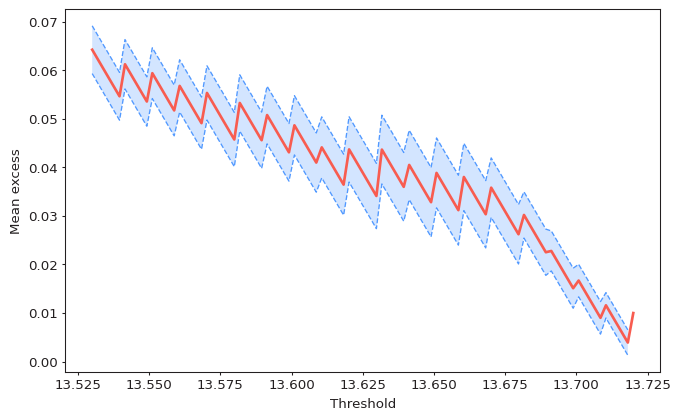

In [62]:
pyextremes.plot_mean_residual_life(ts=contiguous_batch,extremes_type="high")

(<Figure size 768x480 with 1 Axes>,
 <AxesSubplot:xlabel='Date', ylabel='Q-factor'>)

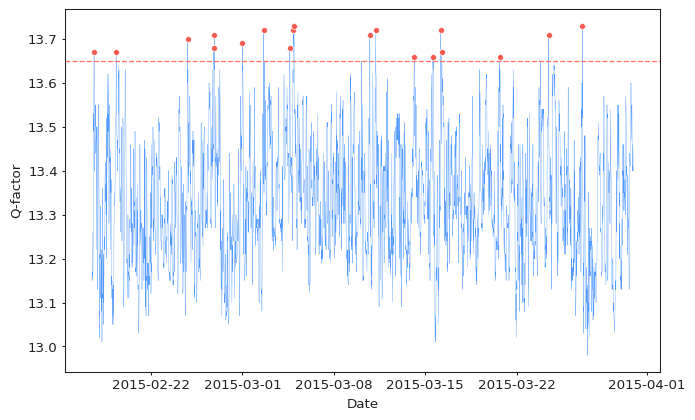

In [61]:
model_POT = EVA(contiguous_batch)
model_POT.get_extremes(method="POT", threshold=13.65, r="1H", extremes_type='high')
#model_POT.get_extremes(method="POT", threshold=13.1, r="1H", extremes_type='low')
model_POT.plot_extremes()

In [59]:
model_POT.fit_model()

/Users/joshnevin/ext_val_stats/evs_env/lib/python3.8/site-packages/pyextremes/eva.py:1478: UserWarning: You passed a edgecolor/edgecolors ('None') for an unfilled marker ('|').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax_pdf.scatter(


(<Figure size 768x768 with 4 Axes>,
 (<AxesSubplot:title={'center':'Return value plot'}, xlabel='Return period', ylabel='Q-factor'>,
  <AxesSubplot:title={'center':'Probability density plot'}, xlabel='Q-factor', ylabel='Probability density'>,
  <AxesSubplot:title={'center':'Q-Q plot'}, xlabel='Theoretical', ylabel='Observed'>,
  <AxesSubplot:title={'center':'P-P plot'}, xlabel='Theoretical', ylabel='Observed'>))

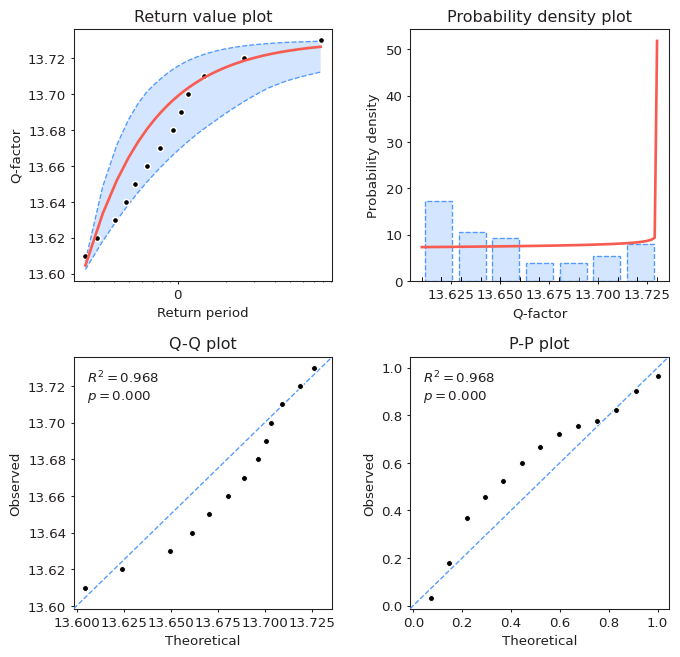

In [60]:
model_POT.plot_diagnostic(alpha=0.95)